This notebook is used to visualize the centre-of-mass positions used to estimated the central positions (or radio centres) of the detected radio sources. <br>

In [1]:
import sys
import os, errno
import os.path as osp
import glob
import re
import math
sys.path.append('/users/cmofokeng/rgz_rcnn/tools/')

import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='serif', weight='bold',size=20)
plt.rc('axes',labelweight='bold',labelsize='large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')


import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import unique
from astropy.io.votable import parse_single_table
from regions import DS9Parser

from astropy.coordinates import SkyCoord
from scipy.ndimage.measurements import center_of_mass
#from matplotlib.path import Path
import matplotlib.patches as patches
from photutils import centroid_com
from astropy.wcs import WCS
from astropy.io import fits
from fuse_radio_ir import fuse
from functions import hosts_overlay, zscale, ds9_bbox_reg
from photutils import detect_threshold, detect_sources, source_properties
from astropy.stats import sigma_clipped_stats,sigma_clip

import cv2
%matplotlib inline

In [2]:
# Read data
data_D4 = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_final_catalogue_v5.csv")
#data_D4_zero = ascii.read("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_final_catalog_v2.csv") # same data however, 
                                                                                                        # assigned the value of zero to pixels with negative values 
                                                                                                        # before COM calculation

## center of mass calculation.

In [91]:
data =  data_D4[data_D4['Class']!='1C_1P'].sample(n=1) # take a random sample data
#data =  data_D4[data_D4['Source_ID']==6337]#.sample(n=1)

In [92]:
data

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
5585,5854,3C_3P,0.9999,241.2878,55.1995,241.2679,55.2109,241.278,55.2048,241.2738,55.2017


In [93]:
# store coordinates of the bounding box as an instance of skycoord
#ul = SkyCoord(data['x1'].iloc[1],data['y1'].iloc[1], frame='icrs', unit ='deg')
ul = SkyCoord(data['x1'],data['y1'], frame='icrs', unit ='deg')
#lr = SkyCoord(data['x2'].iloc[1],data['y2'].iloc[1], frame='icrs', unit ='deg')
lr = SkyCoord(data['x2'],data['y2'], frame='icrs', unit ='deg')

In [94]:
# to convert skycoord to pixel, wcs infromation is required.
fits_dir = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/" # directory with all the FITS files for both radio and infrared data

fits_file = 'gmrt_en1w610_clipped_' + str(data['Source_ID'].iloc[0]) + '.fits'
fits_file = osp.join(fits_dir,fits_file)
with fits.open(fits_file) as file:
    hduradio = file[0]
    wcsradio = WCS(hduradio.header, naxis=2)
    fits_data = hduradio.data

In [95]:
# 3-sigma clipping the data
filtered_fits = sigma_clip(fits_data,return_bounds=True)

In [96]:
# lower and upper bounds of 3-sigma clip
filtered_fits[1],filtered_fits[2]

(-0.00012831263722237215, 0.0001361246864840739)

In [115]:
# compute stats of ours image data
mean, median, std = sigma_clipped_stats(fits_data)
print("mean = {}, median = {}, standard deviation = {}".format(mean, median, std))

mean = 3.032926643636546e-06, median = 7.058351059185952e-07, standard deviation = 4.252220217771207e-05


In [98]:
# lower and upper bounds of the 3-sigma clip
median-3*std,median+3*std

(-0.00012831263722237215, 0.0001361246864840739)

the above computations of 3-sigma (either by using a "sigma_clip" function or manual computation) clipping results in similar lower and upper bounds of the clip

In [99]:
lower_thresh = median-3*std
upper_thresh = median+3*std

In [100]:
# to be used for DS9 reg files
x1 = data['x1'].iloc[0]
y1 = data['y1'].iloc[0]
x2 = data['x2'].iloc[0]
y2 = data['y2'].iloc[0]

x,y,h,w = ds9_bbox_reg(x1,y1,x2,y2,wcsradio)

In [101]:
# convert the coordinates of the bounding box to pixels
upper_left = ul.to_pixel(wcsradio)
lower_right = lr.to_pixel(wcsradio)

In [102]:
# convert y_values of the boxes, to handle the ordering of pixesl between FITS files and python images
y1_flip = hosts_overlay(0,upper_left[1],181/2,181/2,-np.pi)
y2_flip = hosts_overlay(0,lower_right[1],181/2,181/2,-np.pi)

In [103]:
# indexing, FITS is 1-based index, whereas Python is 0-based.
ymin_index = y2_flip[1]#-1
xmin_index = upper_left[0]#-1

In [104]:

#mean,med,std = sigma_clipped_stats(fits_data)
fits_roi = fits_data[int(ymin_index):int(y1_flip[1]),int(xmin_index):int(lower_right[0])]

#thresh_roi = threshold[int(y2_flip[1]):int(y1_flip[1]),int(upper_left[0]):int(lower_right[0])]

#segm = detect_sources(fits_roi, thresh_roi, npixels=5)

zmin,zmax = zscale(fits_data) # convert to zscale used in DS9
#source_props = source_properties(fits_roi,segm)

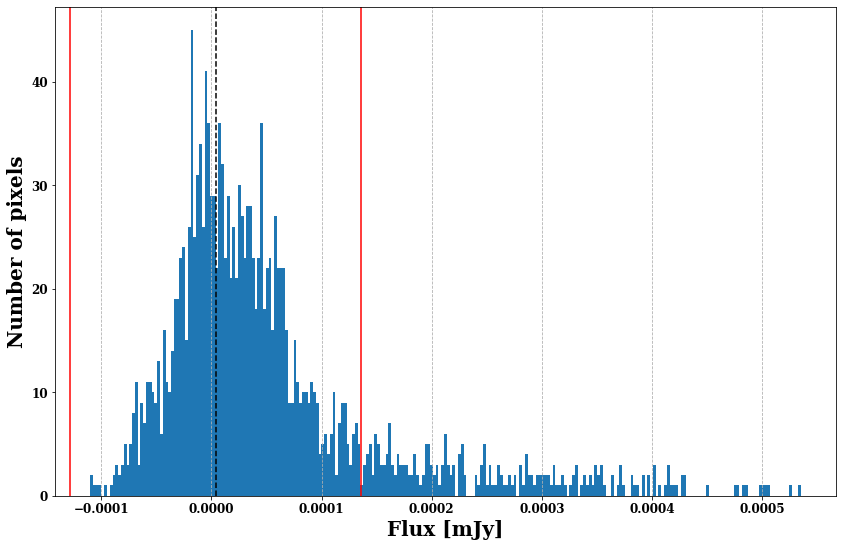

In [105]:
plt.figure(figsize=(14,9))
#vals = fits_roi.mean(axis=0).flatten()
# plot histogram with 255 bins
b, bins, patches = plt.hist(fits_roi.flatten(),bins=255)
#plt.xlim([0,255])
plt.axvline(x=median,c='k',linestyle='--')
plt.axvline(x=upper_thresh,c='r')
plt.axvline(x=lower_thresh,c='r')
plt.grid(which='major',linestyle='dashed',axis='x')
plt.xlabel('Flux [mJy]', fontsize=20)
#plt.xscale('log')
plt.ylabel('Number of pixels', fontsize=20)
plt.show()

The above figure shows flux density distribution from the FITS image data, the peak at low flux values erpresents the background noise in the image while the the sources we are interested in are at the bright end of this distribution. As a result, to successfully recover radio sources, the background needs to be removed (or clipped). The red solid lines represents the lower and the upper boundaries of the 3-sigma clip process and the black dashed line represent the median of this distribution.

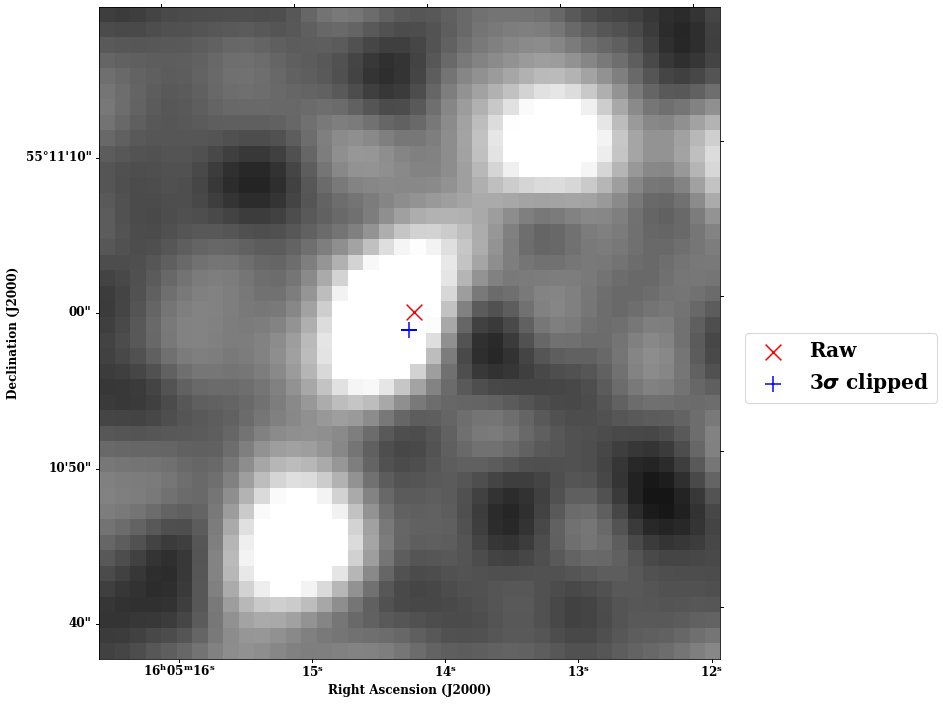

In [106]:
raw_com = np.array(center_of_mass(fits_roi))

plt.figure(figsize=(12,12))

ax = plt.gca(projection=wcsradio)

ax.imshow(fits_roi,cmap='gray', vmin=zmin, vmax=zmax, origin='lower')
fits_roi[fits_roi<lower_thresh] = 0.0
#fits_roi[fits_roi<0.0] = 0.0
fits_roi[fits_roi<upper_thresh] = 0.0

clipped_com = np.array(center_of_mass(fits_roi))

ax.scatter(raw_com[1],raw_com[0],s=250,c='red',marker='x', label='Raw')
ax.scatter(clipped_com[1],clipped_com[0],s=250,c='blue',marker='+', label=r'3$\sigma$ clipped')
#ax.scatter(41.0,76.9,s=250,c='green',marker='+', label=r'3$\sigma$ clipped')
plt.xlabel("Right Ascension (J2000)")
plt.ylabel("Declination (J2000)")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="upper left", fontsize=20, borderaxespad=0)
plt.show()

In [107]:
raw_sky_coords = SkyCoord.from_pixel(raw_com[1],raw_com[0],wcsradio)

In [108]:
raw_sky_coords

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (241.30902193, 55.18319027)>

In [109]:
clipped_sky_coords = SkyCoord.from_pixel(clipped_com[1],clipped_com[0],wcsradio)

In [110]:
raw_sky_coords.separation(clipped_sky_coords).arcsec

1.1418380482239792

In [111]:
# calculate central positions on the larger cutout
raw = np.array([ymin_index,xmin_index]) + np.array([-raw_com[0],raw_com[1]])
clipped = np.array([ymin_index,xmin_index]) + np.array([-clipped_com[0],clipped_com[1]])

In [112]:
raw,clipped

(array([[35.23555146, 76.86226957],
        [39.90488531, 81.53160342]]),
 array([[36.34151998, 76.57847241],
        [41.01085383, 81.24780626]]))

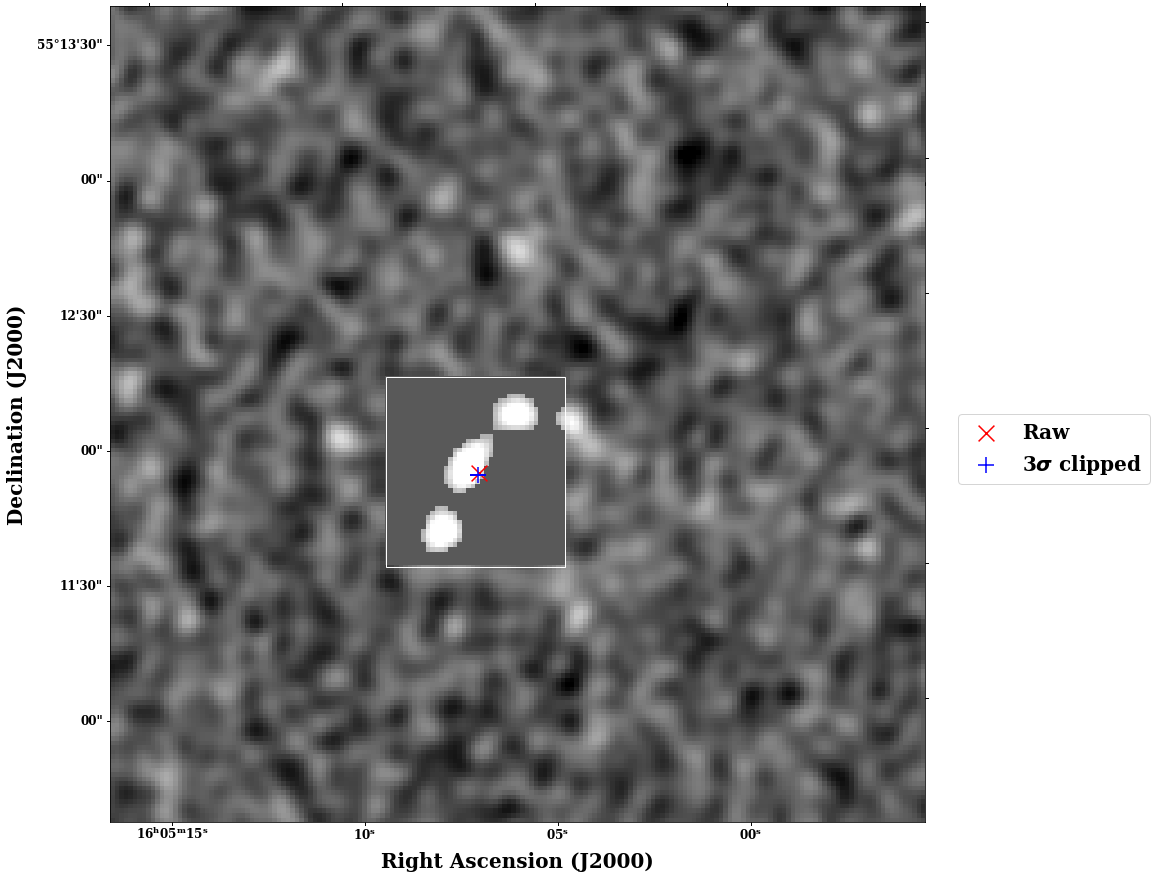

In [113]:
plt.figure(figsize=(15,15))

ax = plt.gca(projection=wcsradio)

ax.imshow(fits_data,cmap='gray', vmin=zmin, vmax=zmax, origin='lower')
ax.scatter(raw[1][1],raw[0][1],s=250,c='red',marker='x', label='Raw')
ax.scatter(clipped[1][1],clipped[0][1],s=250,c='blue',marker='+', label=r'3$\sigma$ clipped')

from matplotlib.patches import Rectangle
r = Rectangle((xmin_index-1, ymin_index-1), w, h, edgecolor='white', facecolor='none')
ax.add_patch(r)

plt.xlabel("Right Ascension (J2000)", fontsize=20)
plt.ylabel("Declination (J2000)", fontsize=20)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="upper left", fontsize=20, borderaxespad=0)
plt.show()

The above visualization uses the zscale algorithm. The zscale algorithm is designed to display the image values near the median image value.